# Chapter 7
## Recurrent neural networks


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).

Learning goals:
1. Get familiar with recurrent hidden units
1. Implement a simple recurrent neural network (Elman network)
1. Implement an LSTM-based neural network

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import chainer
import chainer.functions as F
from chainer.datasets import TupleDataset
from chainer import Chain
import chainer.links as L
import tqdm

/home/greenspray/anaconda3/envs/ml/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Exercise 1  (1 point)

Consider a recurrent neural network with one input unit $x$, one sigmoid recurrent hidden unit $h$, and one linear output unit $y$. The values of $x$ are given for 3 time points in `x_t`. As this is a very small RNN, $W^i$, $W^h$ and $W^o$ are given as the scalar values `w_i`, `w_h` and `w_o` respectively. The hidden unit has an added bias `h_bias`. The hidden unit state is initialized with `0.0`. The only 'value-manipulating' activation function in this network is the sigmoid activation $\sigma(\cdot)$ on the hidden unit. 

1. Write down the forward pass of this network for a specific time point $t$. 
1. What is the value of the hidden state $h$ after processing the last input `x_t[2]`? 
1. What is the output `y` of the network after processing the last input `x_t[2]`? 

\begin{eqnarray*}
h_t &=& 0.07534609\\ 
y_t &=& 0.48681749 \\
\end{eqnarray*}


You can either compute the solution by hand (show clearly how you arrived there, 3 decimal points) or write code to find the answer. 

In [2]:
# inputs over times 0, 1, 2:
x_t = [9.0, 4.0, -2.0]

# weights and bias terms: 
w_i = 0.5
w_h = -1.0
w_o = -0.7
h_bias = -1.0
y_bias = 0.0

### Solution 1

In [3]:
def sigmoid(A):
    """
    Computes the sigmoid activation function.
    INPUT:
        A = [H N] activity matrix of H units for N examples
    OUTPUT
        Y = [H N] output matrix of H units for N examples
    """
    ### Add your code here. ###
    Y = 1/(1+np.exp(-A))
    return Y

h = np.zeros(len(x_t))
y = np.zeros(len(x_t))

# h[0] = sigmoid( w_i * x_t[0] + h_bias)
for t in range(0,len(x_t)):
    h[t] = sigmoid(w_i * x_t[t] + w_h * h[t-1] + h_bias) 
    y[t] = sigmoid(w_o * h[t] + y_bias ) 

print "h : " , h
print "y : " , y


h :  [0.97068777 0.50732753 0.07534609]
y :  [0.33637705 0.41213914 0.48681749]


### Code introduction

We will apply two recurrent neural networks to learn a dynamic variant of the *adding problem*. First, run the next cell and check the output. 

There is a stream of inputs to the network, two at each time step. The first input unit will receive a series of decimal numbers in the interval $[-1,1]$. The second input unit will receive the numbers $0$, $-1$, and $1$. The target is the sum of the preceding two decimal numbers that came together with the number $1$ (called the marker, `x` in the generated output), and it should be produced whenever a marker has been seen. In the beginning until two of these markers have been seen, the input will stay 0. 


Below you will find several functions: 
1. `create_addition_data`: Generates sequential training data sets `X` and `T` for the dynamic *adding problem*, returns a `TupleDataset` for `chainer`.
1. `SequentialIterator`: An `Iterator` determines in which order to traverse a training data set. If you have separate individual examples it is best to use a random order. As our data set is sequential, we need to go through it from beginning to end, which is what we implement in this custom `Iterator`. 
1. `train_model`: A function that takes your model definition and the generated data, and trains the parameters accordingly.
4. `Regressor`: Structure for defining a regression problem. Calls a `predictor` (model doing regression) with an input and returns the error between its output and the desired output. 

Code example for generating your data and setting up the `SequentialIterator` on it:  

`train_iter = SequentialIterator( create_addition_data(n_samples), batch_size=batch_size )`


Code example for training a model:

`model, train_loss, test_loss = train_model( train_iter, test_iter, n_epochs=n_epochs)`

In [4]:
def create_addition_data(n_samples=3000):
    # This is a dynamic variant of the adding problem. 
    
    # random numbers in [-1.0,1.0]): 
    X1 = np.random.uniform(low=-1.0, high=1.0, size=(n_samples,) )   
    
    # random markers [-1.0, 0.0, 1.0] (1.0 marks the numbers that should be added):
    X2 = np.random.choice([-1.0,0.0,1.0], size=(n_samples,), p=[0.475,0.475,0.05])
    # combine
    X = np.vstack((X1, X2)).T.astype('float32')

    # create targets
    T = np.zeros( (n_samples,1) ).astype('float32')

    markers = np.nonzero(X2==1.0)[0]   # get indices of 1.0
    
    mem = X1[ markers[0] ]
    for mi, marker in enumerate(markers[1:]):
        T[marker] = mem + X1[ marker ]
        mem = X1[ marker ]
                
    return TupleDataset(X, T)


n = 70  # long as the markers x are sparse

print "Example data for the adding problem (x marks 1.0):"
data = create_addition_data(n_samples=n)

for t in xrange(n):
    print "Time=%2d:   x: (%+.2f , %s )  |  t:  %+.2f " % (t, data[t][0][0], 
                                                        'x' if data[t][0][1] == 1.0 else ' ', 
                                                        data[t][1])

Example data for the adding problem (x marks 1.0):
Time= 0:   x: (-0.37 ,   )  |  t:  +0.00 
Time= 1:   x: (-0.04 ,   )  |  t:  +0.00 
Time= 2:   x: (-0.84 ,   )  |  t:  +0.00 
Time= 3:   x: (+0.35 ,   )  |  t:  +0.00 
Time= 4:   x: (-0.03 ,   )  |  t:  +0.00 
Time= 5:   x: (-0.87 ,   )  |  t:  +0.00 
Time= 6:   x: (-0.47 ,   )  |  t:  +0.00 
Time= 7:   x: (+0.90 ,   )  |  t:  +0.00 
Time= 8:   x: (+0.25 ,   )  |  t:  +0.00 
Time= 9:   x: (+0.31 ,   )  |  t:  +0.00 
Time=10:   x: (+0.53 ,   )  |  t:  +0.00 
Time=11:   x: (+0.39 ,   )  |  t:  +0.00 
Time=12:   x: (-0.93 ,   )  |  t:  +0.00 
Time=13:   x: (+0.29 ,   )  |  t:  +0.00 
Time=14:   x: (+0.79 ,   )  |  t:  +0.00 
Time=15:   x: (-0.98 ,   )  |  t:  +0.00 
Time=16:   x: (+0.24 ,   )  |  t:  +0.00 
Time=17:   x: (+0.39 ,   )  |  t:  +0.00 
Time=18:   x: (-0.70 ,   )  |  t:  +0.00 
Time=19:   x: (+0.97 ,   )  |  t:  +0.00 
Time=20:   x: (-0.25 ,   )  |  t:  +0.00 
Time=21:   x: (-0.26 ,   )  |  t:  +0.00 
Time=22:   x: (-0.03 ,   

In [5]:
class SequentialIterator(object):

    def __init__(self, data, batch_size=1):
        self.data = data

        self.batch_size = batch_size
        self.n_batches = len(self.data) // batch_size

    def __iter__(self):

        self.idx = -1

        offsets = [i * self.n_batches for i in range(self.batch_size)]

        # define custom ordering; we won't process beyond the end of the trial
        self._order = []
        for iter in range(self.n_batches):
            x = [(offset + iter) % len(self.data) for offset in offsets]
            self._order += x

        return self

    def next(self):

        self.idx += 1

        if self.idx == self.n_batches:
            raise StopIteration

        i = self.idx * self.batch_size
        
        test = list(self.data[self._order[i:(i + self.batch_size)]])

        return list(self.data[self._order[i:(i + self.batch_size)]])

In [6]:
def train_network(model, n_samples=3000, n_epochs=100): 
    
    batchsize = 20
    
    # Define data iterators
    train_iter = SequentialIterator(create_addition_data(n_samples), batch_size=batchsize)
    test_iter  = SequentialIterator(create_addition_data(n_samples), batch_size=batchsize)
    
    cutoff = n_samples / batchsize - 1
    cutoff = 70

    # Preallocate memory for losses
    train_loss = np.zeros(n_epochs)
    test_loss = np.zeros(n_epochs)
    
    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Loop over epochs
    for epoch in tqdm.tqdm(xrange(n_epochs)):

        # Training
        with chainer.using_config('train', True):

            # Reset
            model.predictor.reset_state()
            counter = 0
            loss = None

            # Loop over batches
            for data in train_iter:

                counter += 1

                # Apply model
                _loss = model(data[0], data[1])
                train_loss[epoch] += _loss.data

                # Gather losses
                if loss is None:
                    loss = _loss
                else:
                    loss += _loss

                # Update weights
                if counter % cutoff == 0:

                    # Backprop
                    model.cleargrads()
                    loss.backward()
                    optimizer.update()

                    # Resets root of the loss to the current position 
                    # (chops off computation history):
                    loss.unchain_backward()

                    # Reset loss
                    loss = None

        # Normalize loss
        train_loss[epoch] /= train_iter.data._length

        # Validation
        with chainer.using_config('train', False):

            model.predictor.reset_state()

            # Loop over batches
            for data in test_iter:

                # Apply model
                test_loss[epoch] += model(data[0], data[1]).data

        # Normalize loss
        test_loss[epoch] /= test_iter.data._length
        
    return model, train_loss, test_loss

In [7]:
class Regressor(Chain):

    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
      
        y = self.predictor(x)
        
        loss = F.mean_squared_error(y, t)
        return loss

### Exercise 2: Testing a network  (2 points)

As in previous exercises, we still would like to have a function to test a trained `model`. Assume that `model` is an instance of the `Regressor` class. This function should do the following: 

1. Generate a new `test` data set, and from it a `test_iter` sequential iterator. It should have `n_samples` data points. 
1. Let `model.predictor` predict outputs on the test set. For this, iterate through the sequential `test_iter` and pass each `datapoint` through `model.predictor`. 
1. Save the model output in `pred` and the desired output in `real`. 
1. For comparison, plot the model output and the the desired output into the same figure. (Add a legend to denote what is what. Plot at least 500 examples.)

Your generated data set is a `TupleDataset`. Each data point will thus be a tuple `(x,t)`, where `x` are the inputs and `t` the desired outputs.

The recurrent neural network architectures we want to try will be implemented in the next exercises.

### Solution 2

In [8]:
# Function to test a model
def test_network(model, n_samples=3000):
    pred = np.zeros(n_samples)
    real = np.zeros(n_samples)
    
    # Generate some test data
    test = create_addition_data(n_samples=n_samples)
    test_iter  = SequentialIterator(test)

    
    # Reset the hidden state before starting to predict:
    model.predictor.reset_state()

    # Save predicted / desired outputs in pred / real.
    for idx, datapoint in enumerate(test_iter):
        a = model.predictor(datapoint[0])        
        pred[idx] = a.data        
        real[idx] = datapoint[1]
    
        
    len_data = n_samples
    
    plt.figure(figsize=(20,8))
    plt.title('Predicted vs real ')
    plt.plot(range(len_data),pred)
    plt.plot(range(len_data), real,c='g')
    blue_patch = mpatches.Patch(color='blue', label='Predicted')
    green_patch = mpatches.Patch(color='green', label='Real')
    plt.ylabel('Value')
    plt.xlabel('Sample')
    plt.legend(handles=[blue_patch,green_patch])
    plt.show()
    

### Exercise 3: Simple RNN  (3 points)

We first implement a simple recurrent architecture (a simple [Elman network](http://mnemstudio.org/neural-networks-elman.htm)). 

1. First implement the linear layers `l1` and `l2`. They should lead from `n_input` input units over `n_hidden` hidden units to `n_out` output units.
1. Add a recurrent linear weight layer `hr`. These are weights that self-connect to the hidden units. The input will be the values of the `n_hidden` hidden units, and they should project back to the `n_hidden` hidden units. 
1. A forward pass will update the hidden state with the inputs and the recurrent layer weights, and produce the output from the hidden unit. Specifically you should do the following: 
    2. If `self.hstate` contains no value yet (is `None`), it should be set to the input passed through `l1` and `tanh` activations.
    2. If `self.hstate` contains a value: a) Pass the input through `l1` and `tanh` activations. b) Pass `self.hstate` through the recurrent weight layer `hr`. The sum of a) and b) should be the new `self.hstate`.
    2. Finally pass `self.hstate` through layer `l2`. This produces the output `y`.
1. Fill in the function `reset_state()` that resets `self.hstate` back to  `None`.

### Solution 3

In [9]:
class SimpleRNN(Chain):
    
    def __init__(self, n_hidden, n_input=2, n_out=1):
        super(SimpleRNN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(in_size=n_input,out_size=n_hidden)
            self.l2 = L.Linear(in_size=n_hidden,out_size=n_out)
            self.hr = L.Linear(in_size=n_hidden,out_size=n_hidden)
        
        # initialize hidden state with None
        self.hstate = None
    
    def __call__(self, x):
        if self.hstate is None:
            self.hstate = F.tanh(self.l1(x))
        else:
            linear_activation = F.tanh(self.l1(x))
            rnn_activation = self.hr(self.hstate)
            self.hstate = linear_activation + rnn_activation
        
        return self.l2(self.hstate)
    
    
    def reset_state(self):
        self.hstate = None

### Exercise 3: Setup and run (1 point)

Try your `SimpleRNN` with the dynamic addition task. 

1. Define the model. `SimpleRNN` should have **4 hidden units** and become the predictor of a `Regressor` instance. 
1. Train your model for 500 epochs on a dataset of 3000 samples with `train_network`.
1. Plot the train and validation losses. 
1. Finally, use the trained model together with `test_network` (at least 500 examples) to observe how predictions and real data compare. 

Based on the losses and predictions, what would your conclusion be? Did the simple RNN learn the task? 

### Solution 3

In [10]:
# Define model
model = Regressor ( SimpleRNN(n_hidden = 4) )

# Train model
epochs  = 500
samples = 3000
model, train_loss, val_loss = train_network(model, n_samples = 3000, n_epochs= 500)

# Plot losses
# Plot predictions vs. real data
# See cell below

100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


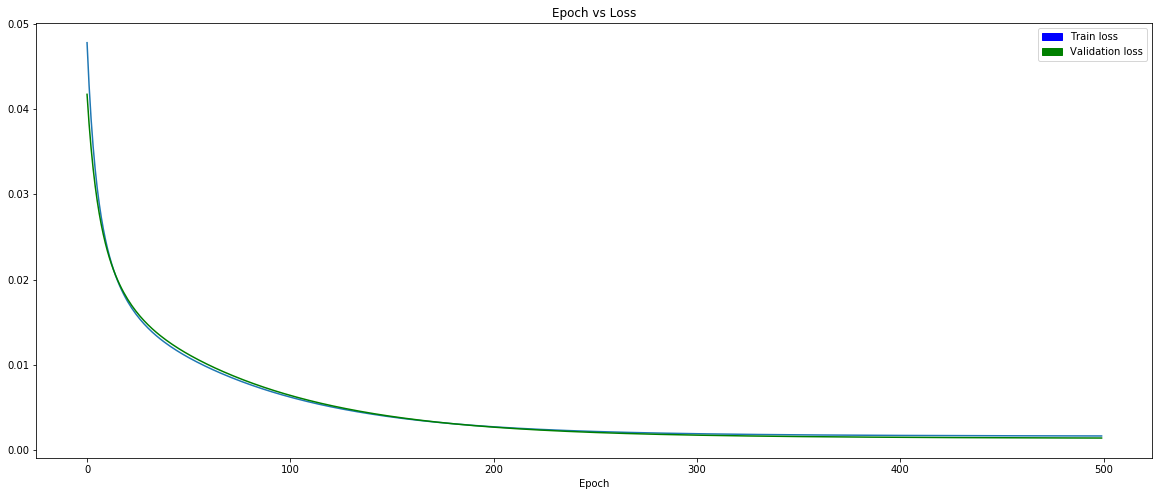

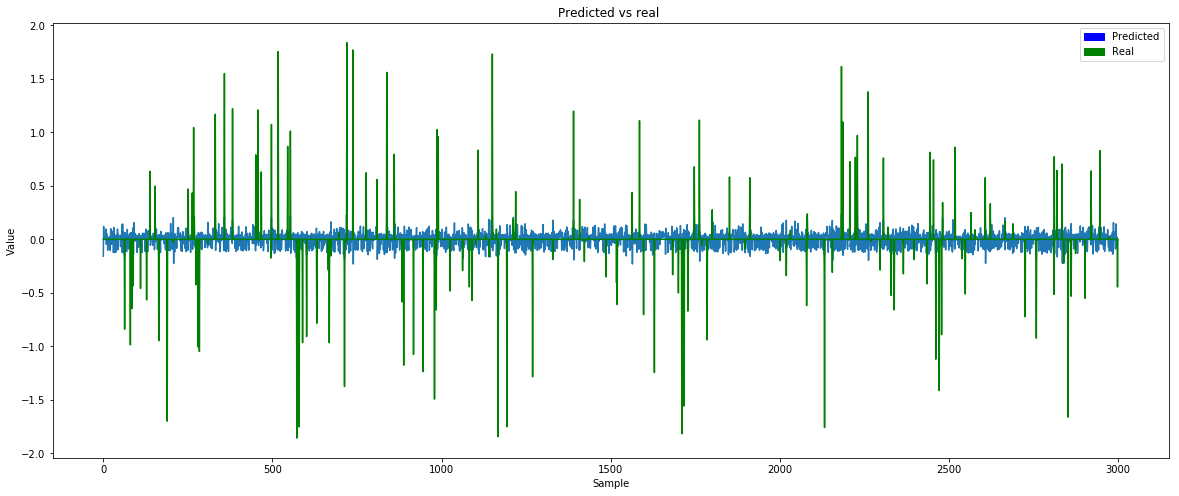

In [11]:
import matplotlib.patches as mpatches

len_data = len(train_loss)
plt.figure(figsize=(20,8))
plt.title('Epoch vs Loss')
plt.plot(range(len_data),train_loss)
plt.plot(range(len_data), val_loss, c = 'g')
plt.xlabel('Epoch')
blue_patch = mpatches.Patch(color='blue', label='Train loss')
green_patch = mpatches.Patch(color='green', label='Validation loss')
plt.legend(handles=[blue_patch,green_patch])


# Plot predictions vs real data
test_network(model)
plt.show()

If we consider the loss plot, it seems as if the network performs well. However, when we consider the plot contrasting predictions with the real data we see that none of the large green spikes (real values) are matched in size by the blue spikes (predicted values).
Furthermore, predicted spikes occur much more frequently than real spikes. Overall the predicted data looks very noisy and mostly random. The plot of the losses thus seems somewhat misleading. The pattern in the data is not learned properly by the network, but the overall loss is still low because the real data is sparse: the network continuously predicts low values, but since high real values are rare and most are very low, the network is still accurate *on average*.

### Exercise 4: LSTM RNN (2 points)

Long-Short Term Memory (LSTM) units have more [powerful functionality](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), such as selective forgetting, and they are able to keep track of long-term dependencies. This might be useful for the adding task. 

Implement `LSTM_RNN`:

1. `lstm` should be an `LSTM` layer leading from the `n_input` inputs to the `n_hidden` hidden units.
1. `fc` should be a fully-connected (linear) layer leading from the hidden units (output of `lstm`) to the `n_out` output units. 
1. The network does not make use of further activation functions. 
1. Fill in the function `reset_state()` by calling the reset function (with the same name) on the `lstm` layer there.

### Solution 4

In [12]:
class LSTM_RNN(Chain):
    
    def __init__(self, n_hidden, n_input=2, n_out=1):
        super(LSTM_RNN, self).__init__()
        with self.init_scope():
            self.lstm = L.LSTM(in_size=n_input,out_size=n_hidden)
            self.fc = L.Linear(in_size=n_hidden,out_size=n_out)
    
    def __call__(self,x):
            rnn_activation = self.fc(self.lstm(x))
            return rnn_activation
    
    def reset_state(self):
            self.lstm.reset_state()

### Exercise 5: Setup and run (1 point)

Try your `LSTM_RNN` with the dynamic addition task. 

1. Define the model. `LSTM_RNN` should have **2 hidden units** and become the predictor of a `Regressor` instance.  
1. Train your model for 2000 epochs on a dataset of 3000 samples with `train_network`. 
1. Plot the train and validation losses. 
1. Finally, use the trained model together with `test_network` (at least 500 examples) to observe how predictions and real data compare. 

Did the LSTM network capture the task better? Did any of the two capture the task perfectly? Or are the two networks on par? 

### Solution 5

In [13]:
# Define model

model = Regressor ( LSTM_RNN(n_hidden = 2) )

# Train model

epochs  = 2000
samples = 3000
model, train_loss, val_loss = train_network(model, n_samples = samples, n_epochs= epochs)

# See cell below for plots


100%|██████████| 2000/2000 [09:55<00:00,  3.36it/s]


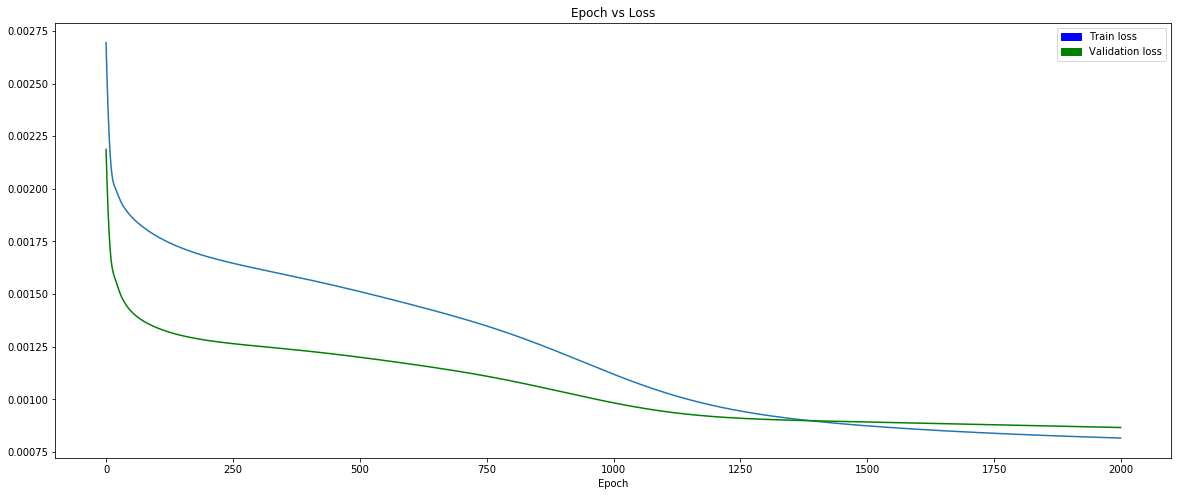

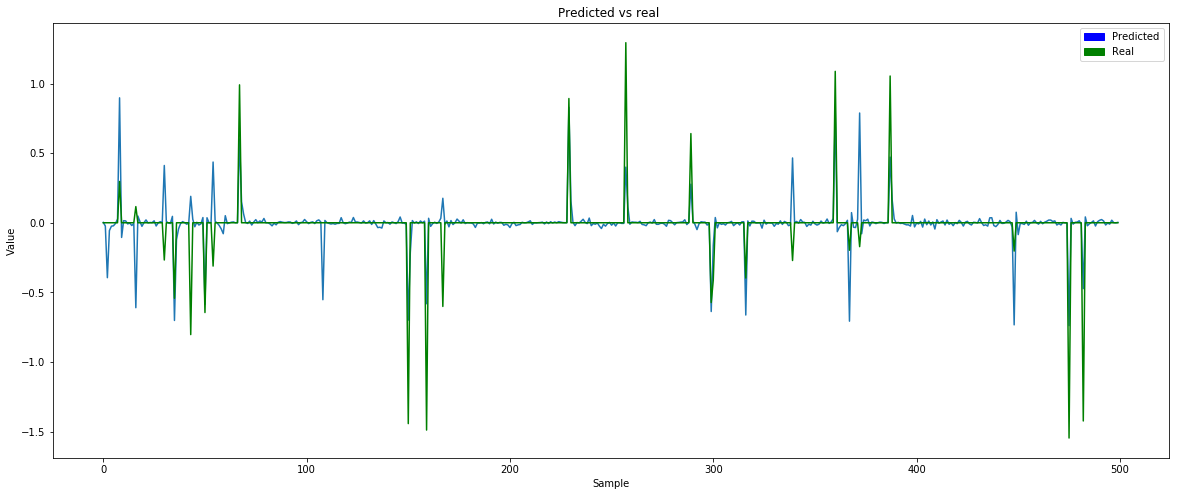

In [14]:
# Plot losses
import matplotlib.patches as mpatches

len_data = len(train_loss)
plt.figure(figsize=(20,8))
plt.title('Epoch vs Loss')
plt.plot(range(len_data),train_loss)
plt.plot(range(len_data), val_loss, c = 'g')
plt.xlabel('Epoch')
blue_patch = mpatches.Patch(color='blue', label='Train loss')
green_patch = mpatches.Patch(color='green', label='Validation loss')
plt.legend(handles=[blue_patch,green_patch])

# Plot predictions vs real data
test_network(model,500)
plt.show()

When comparing the plots showing the loss over epochs we observe that after training the networks the LSTM network achieves a lower training and validation loss. However, it was also trained with significantly more training samples. Looking at the trend in the loss plots both networks seem to have converged after the amount of training they received, suggesting that no further improvements would have been achieved with longer training.

Looking at the plots showing real data points against the corresponding predicted value the LSTM network seems to perform much better as well. The predicted spikes more closely match the spikes in the real data and there are less 'noise' spikes in between real spikes. The magnitude of said spikes also matches those in the real data more closely. Still, the LSTM network sometimes predicts spikes where there should be none and some of the spikes point in the wrong direction (negative values when they should be positive).

The fact that both networks achieve a low loss after training could also be explained by the nature of the data: The simple RNN predicts almost constant but very small spikes. The real data contains few spikes and very low values most of the time. Due to this even a network that always predicts low values is reasonably accurate, even though the underlying pattern was not learned at all.